In [1]:
import pandas as pd
import seaborn as sns
import zipfile
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree

### Загрузка данных

In [2]:

# в архиве находится файл xlsx
# Pandas (пока) не умеет открывать такие файлы из zip
# поэтому воспользуемся распаковщиком

archive = zipfile.ZipFile('./data_ford_price.zip', 'r')
xlsx_file = archive.open('data_ford_price.xlsx')

In [3]:
# читаем данные и показываем верхние строчки

car_price_data_orig = pd.read_excel(xlsx_file)
car_price_data_orig.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [4]:
# делаем копию данных, с которой будем работать

car_data = car_price_data_orig.copy()

### Подготовка данных

#### Удаляем ненужные признаки

In [5]:
# проанализируем данные

car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


Признак `size` является кандидатом на удаление из-за большого кол-ва пропусков.

In [6]:
car_data.describe()

,price,year,condition,cylinders,odometer,lat,long,weather
count,7017.000000,7017.000000,7017.000000,7017.000000,7.017000e+03,7017.000000,7017.000000,6837.000000
mean,15121.549523,2007.869745,2.598689,7.374662,1.199787e+05,39.550144,-91.903404,52.142899
std,11765.423119,6.975329,0.703662,0.942928,8.992216e+04,5.745409,14.030710,7.954830
min,1.000000,1957.000000,0.000000,3.000000,0.000000e+00,-2.508807,-151.055832,29.000000
25%,5995.000000,2004.000000,2.000000,6.000000,7.328500e+04,35.661076,-95.937145,45.000000
50%,12750.000000,2010.000000,3.000000,8.000000,1.180000e+05,40.335245,-88.168416,51.000000
75%,21995.000000,2013.000000,3.000000,8.000000,1.578040e+05,43.582100,-82.706300,59.000000
max,299500.000000,2018.000000,5.000000,10.000000,2.490000e+06,77.617682,-5.377999,71.000000


Признак `long` (долгота) также является кандидатом на удаление, поскольку он не несет полезной информации. Теоретически мы могли бы использовать широту и долготу чтобы получить страну и город. Но маловероятно, что полученные дополнительные признаки смогут войти в тройку наиболее важных.

In [7]:
car_data.describe(include='object')

,title_status,transmission,drive,size
count,7017,7017,6626,5453
unique,5,3,3,4
top,clean,automatic,4wd,full-size
freq,6657,6708,4888,4570


Среди категориальных призаков нет кандидатов на удаление.

Итого у нас два кандидата на удаление `long` и `size`. Удалим только долготу, а размер оставим на всякий случай.

In [8]:
car_data.drop(columns=['long'], inplace=True)

#### Обрабатываем пропуски

In [9]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  weather       6837 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 603.1+ KB


У нас есть `3` признака с пропущенными данными: `size`, `drive` и `weather`. Заполним пропуски в категориальных признаках модой, а в числовых — медианой.

In [10]:
car_data.fillna({
    'size': car_data['size'].mode()[0],
    'drive': car_data['drive'].mode()[0],
    'weather': car_data['weather'].median(),
}, inplace=True)

In [11]:
# проверяем результат

car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         7017 non-null   object 
 8   size          7017 non-null   object 
 9   lat           7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 603.1+ KB


#### Убираем выбросы

Для начала выясним, в каких признаках у нас могут быть выбросы. В категориальных признаках выбросов быть не может. Посмотрим что в числовых.

In [12]:
car_data.describe()

,price,year,condition,cylinders,odometer,lat,weather
count,7017.000000,7017.000000,7017.000000,7017.000000,7.017000e+03,7017.000000,7017.000000
mean,15121.549523,2007.869745,2.598689,7.374662,1.199787e+05,39.550144,52.113581
std,11765.423119,6.975329,0.703662,0.942928,8.992216e+04,5.745409,7.854202
min,1.000000,1957.000000,0.000000,3.000000,0.000000e+00,-2.508807,29.000000
25%,5995.000000,2004.000000,2.000000,6.000000,7.328500e+04,35.661076,45.000000
50%,12750.000000,2010.000000,3.000000,8.000000,1.180000e+05,40.335245,51.000000
75%,21995.000000,2013.000000,3.000000,8.000000,1.578040e+05,43.582100,59.000000
max,299500.000000,2018.000000,5.000000,10.000000,2.490000e+06,77.617682,71.000000


Судя по таблице выше, выбросы имеются в двух признаках. В признаке `price` слишком маленькое минимальное значение — `$1` — что очень уж мало для авто. В признаке — `odometer` слишком большое максимальное значение — `2.49` миллиона километров (или милей) — что черезчур много для автомобиля.

Посмотрим на диаграмму распределения признаков.

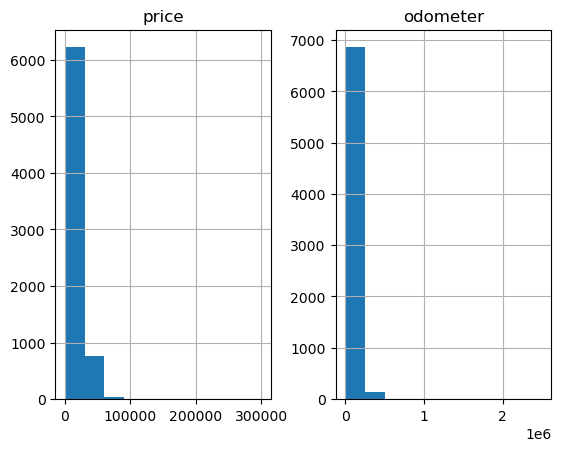

In [13]:
car_data[['price', 'odometer']].hist();

Посмотрим, сколько машин с ценой ниже `100$`.

In [14]:
m = car_data['price'] < 100
m.sum()

69

Не слишком много, мы можем их все убрать.

In [15]:
car_data = car_data[~m]

Посмотрим сколько машин с километражом `> 500K`

In [16]:
m = car_data['odometer'] > 5e5
m.sum()

14

Не слишком много. Уберем их все.

In [17]:
car_data = car_data[~m]

#### Кодируем категориальные признаки

Воспользуемся методом `get_dummies`

In [18]:
car_data_dummies = pd.get_dummies(car_data)

Посмотрим что получилось.

In [19]:
car_data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6934 entries, 0 to 7016
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   6934 non-null   int64  
 1   year                    6934 non-null   int64  
 2   condition               6934 non-null   int64  
 3   cylinders               6934 non-null   int64  
 4   odometer                6934 non-null   int64  
 5   lat                     6934 non-null   float64
 6   weather                 6934 non-null   float64
 7   title_status_clean      6934 non-null   uint8  
 8   title_status_lien       6934 non-null   uint8  
 9   title_status_missing    6934 non-null   uint8  
 10  title_status_rebuilt    6934 non-null   uint8  
 11  title_status_salvage    6934 non-null   uint8  
 12  transmission_automatic  6934 non-null   uint8  
 13  transmission_manual     6934 non-null   uint8  
 14  transmission_other      6934 non-null   

In [20]:
car_data_dummies.head()

,price,year,condition,cylinders,odometer,lat,weather,title_status_clean,title_status_lien,title_status_missing,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,43900,2016,4,6,43500,36.471500,59.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,15490,2009,2,8,98131,40.468826,52.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,2495,2002,2,8,201803,42.477134,45.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3,1300,2000,1,8,170305,40.764373,49.0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
4,13865,2010,3,8,166062,49.210949,51.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [21]:
car_data = car_data_dummies

#### Анализируем признаки на мультиколлинеарность

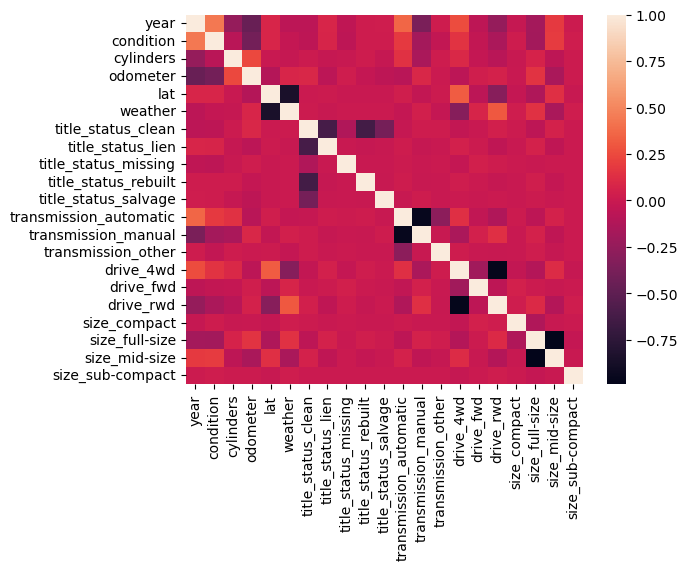

In [22]:
sns.heatmap(car_data.drop(columns=['price']).corr());

Следующие пары признаков, похоже, коллинеарны:

-  `weather` + `lat`
-  `transmission_manual` + `transmission_automatic`
-  `drive_4wd` + `drive_rwd`
-  `sizs_full-size` + `size_mid-size`

Посмотрим на них еще раз

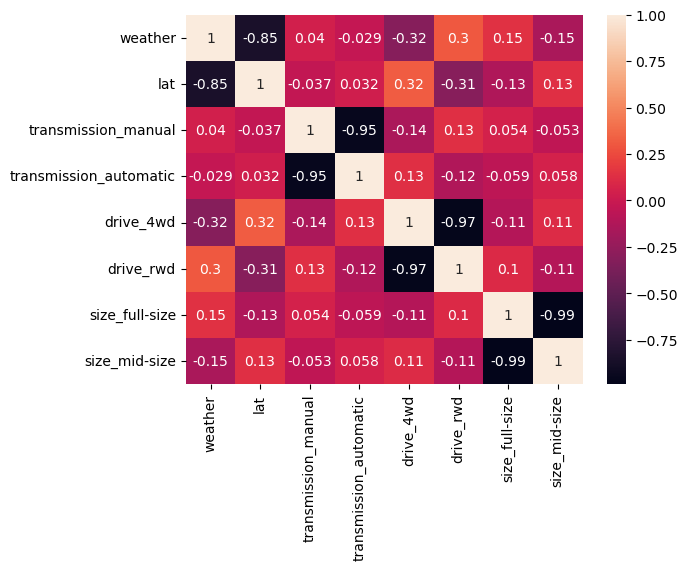

In [23]:
columns = [
    'weather',
    'lat',
    'transmission_manual',
    'transmission_automatic',
    'drive_4wd',
    'drive_rwd',
    'size_full-size',
    'size_mid-size',
]

sns.heatmap(car_data[columns].corr(), annot=True);

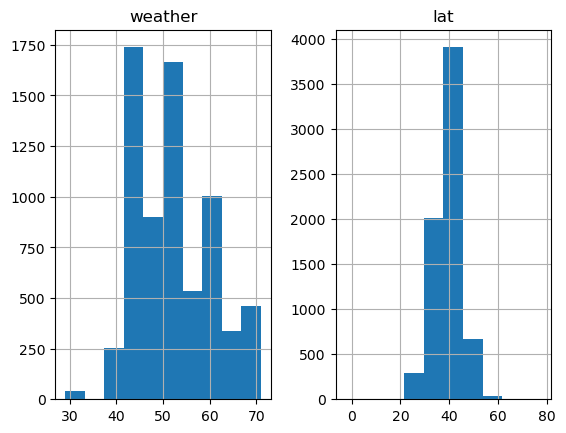

In [24]:
car_data[['weather', 'lat']].hist();


Удаляем один признак из каждой пары. Из первой пары удалим `weather` потому что `lat` имеет нормальное распределение.

In [25]:
columns_to_remove = [
    'weather',
    'transmission_manual',
    'drive_4wd',
    'size_full-size',
]

car_data.drop(columns=columns_to_remove, inplace=True)

Смотрим, что получилось.

In [26]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6934 entries, 0 to 7016
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   6934 non-null   int64  
 1   year                    6934 non-null   int64  
 2   condition               6934 non-null   int64  
 3   cylinders               6934 non-null   int64  
 4   odometer                6934 non-null   int64  
 5   lat                     6934 non-null   float64
 6   title_status_clean      6934 non-null   uint8  
 7   title_status_lien       6934 non-null   uint8  
 8   title_status_missing    6934 non-null   uint8  
 9   title_status_rebuilt    6934 non-null   uint8  
 10  title_status_salvage    6934 non-null   uint8  
 11  transmission_automatic  6934 non-null   uint8  
 12  transmission_other      6934 non-null   uint8  
 13  drive_fwd               6934 non-null   uint8  
 14  drive_rwd               6934 non-null   

#### Трансформируем данные

Посмотрим, как распределены наши данные в наших признаках сейчас.

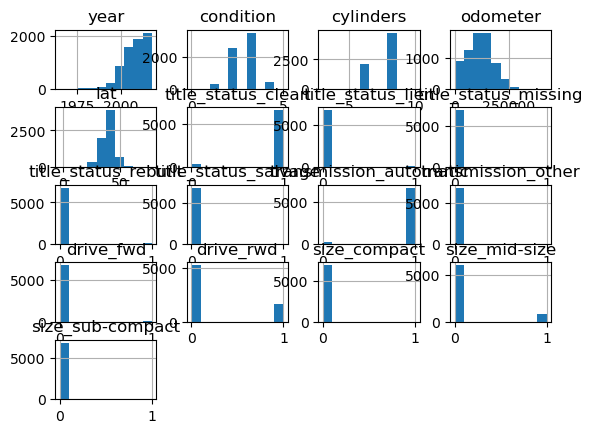

In [27]:
car_data.drop(columns=['price']).hist();

Мы можем трасформировать три признака: `year`, `odometer` и `lat`.

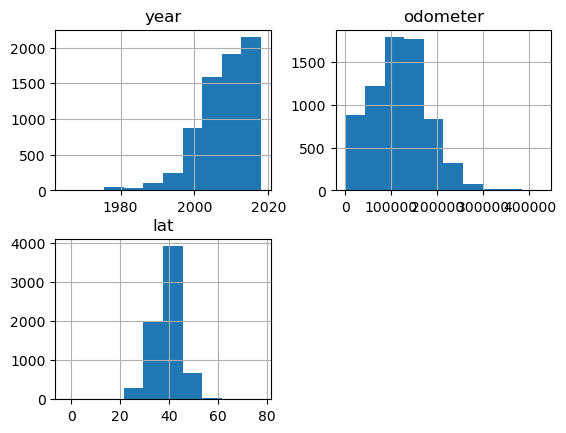

In [28]:
columns = ['year', 'odometer', 'lat']

car_data[columns].hist();

In [29]:
car_data[columns].describe()

,year,odometer,lat
count,6934.000000,6934.000000,6934.000000
mean,2007.908134,117479.179983,39.615304
std,6.877327,61872.004549,5.705333
min,1965.000000,0.000000,-2.508807
25%,2004.000000,73413.250000,35.682381
50%,2010.000000,118412.000000,40.378512
75%,2013.000000,157000.000000,43.607650
max,2018.000000,426000.000000,77.617682


Воспользуемся классом PowerTransformer с методом Йуо-Джонсона. (Мы не можем воспользоваться методом Бокса-Кокса поскольку у `lat` есть отрицательные значения.)

In [30]:
ptr = PowerTransformer(method='yeo-johnson')
columns = ['year', 'odometer', 'lat']
# car_data[columns] = ptr.fit_transform(car_data[columns].values)

Посмотрим, что получилось.

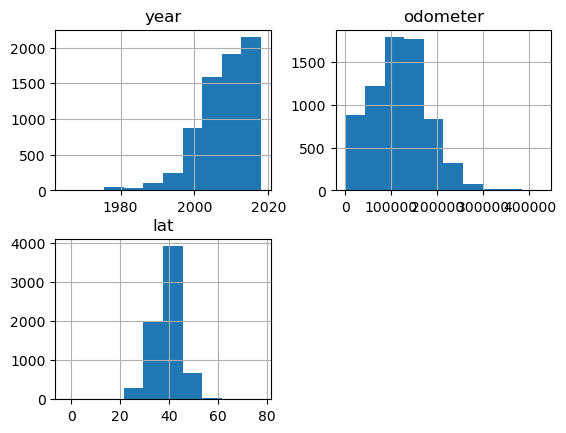

In [31]:
car_data[columns].hist();

### Отбор признаков с помощью `RFE`

In [32]:
X_train = car_data.drop(columns=['price'])
y_train = car_data['price']

In [33]:
# estimator = linear_model.LinearRegression()
estimator = tree.DecisionTreeClassifier()

selector = RFE(estimator, step=1, n_features_to_select=3)
selector = selector.fit(X_train, y_train)
columns_a = selector.get_feature_names_out()

columns_a

array(['year', 'odometer', 'lat'], dtype=object)

### Отбор признаков с помощью `SelectKBest`

In [34]:
selector = SelectKBest(k=3)
selector.fit(X_train, y_train)
columns_b = selector.get_feature_names_out()

columns_b

array(['year', 'odometer', 'size_mid-size'], dtype=object)

### Обучение моделей

In [35]:
y = car_data['price']

X_a = car_data[columns_a]
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y, test_size=0.2, random_state=42)

X_b = car_data[columns_b]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y, test_size=0.2, random_state=42)

lr_model_a = linear_model.LinearRegression()
lr_model_a.fit(X_train_a, y_train_a);

lr_model_b = linear_model.LinearRegression()
lr_model_b.fit(X_train_b, y_train_b);


### Сравнение результатов

In [36]:
def metrics_regression(y, y_pred):
    print(f'MAE: {metrics.mean_absolute_error(y, y_pred)}')
    print(f'MAPE: {metrics.mean_absolute_percentage_error(y, y_pred)}')
    print(f'MSE: {metrics.mean_squared_error(y, y_pred)}')
    print(f'RMSE: {metrics.mean_squared_error(y, y_pred) ** 0.5}')
    print(f'R²: {metrics.r2_score(y, y_pred)}')

print('Метрики модели A (RFE)')
metrics_regression(y_test_a, lr_model_a.predict(X_test_a))

print('\nМетрики модели B (SelectKBest)')
metrics_regression(y_test_b, lr_model_b.predict(X_test_b))

Метрики модели A (RFE)
MAE: 4639.297069124283
MAPE: 0.799745374981175
MSE: 102801617.47212502
RMSE: 10139.113248806576
R²: 0.44643357884027346

Метрики модели B (SelectKBest)
MAE: 4576.199135189938
MAPE: 0.7995711996701598
MSE: 101754865.38145053
RMSE: 10087.361666037881
R²: 0.45207013226155845


### Вывод

Согласно полученному результату, метод `SelectKBest` выбрал более важные признаки. Также стоит заметить, что мы никак его не конфигурировали, то есть не передавали первый параметр `score_func`. При этом он показал лучший результат и скорость его работы достаточно высокая.

Что касается `RFE`, то для получения приличного результата пришлось с ним повозиться. Методом проб и ошибок мы выяснили, что модель `LinearRegression` в качестве первого параметра не дает желаемого эффекта, и что модель `DecisionTree` работает намного лучше. Еще мы выяснили, что скорость его работы напрямую зависит от переданной модели, и что в такой конфигурации (с моделью `DecisionTree`) он работает на порядок дольше, чем `SelectKBest`.